# Análisis de Regresión para Casas con Precios Menores a $3 Millones

## Objetivos:
1. Filtrar dataset para casas < $3M
2. Optimizar hiperparámetros (epochs, batch size, dropout, L2)
3. Comparar diferentes arquitecturas
4. Identificar el mejor modelo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


## 1. Carga y Filtrado de Datos

In [7]:
# Cargar datos
df = pd.read_excel("./kc_house_data_yr.xlsx")
print(f"Dataset original: {df.shape}")
print(f"Precio promedio original: ${df['price'].mean():,.2f}")

# Análisis de distribución
houses_above_3m = (df['price'] >= 3000000).sum()
houses_below_3m = (df['price'] < 3000000).sum()
print(f"Casas >= $3M: {houses_above_3m} ({houses_above_3m/len(df)*100:.1f}%)")
print(f"Casas < $3M: {houses_below_3m} ({houses_below_3m/len(df)*100:.1f}%)")

Dataset original: (21613, 21)
Precio promedio original: $540,088.14
Casas >= $3M: 50 (0.2%)
Casas < $3M: 21563 (99.8%)


Dataset filtrado: (21563, 21)
Precio promedio filtrado: $532,483.39


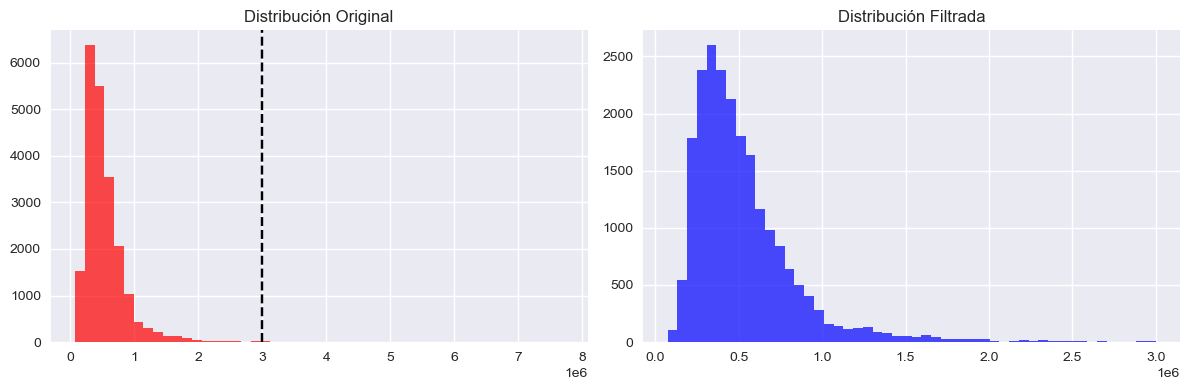

In [13]:
# Filtrar dataset
df_filtered = df[df['price'] < 3000000].copy()
print(f"Dataset filtrado: {df_filtered.shape}")
print(f"Precio promedio filtrado: ${df_filtered['price'].mean():,.2f}")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(df['price'], bins=50, alpha=0.7, color='red', label='Original')
axes[0].axvline(x=3000000, color='black', linestyle='--')
axes[0].set_title('Distribución Original')
axes[1].hist(df_filtered['price'], bins=50, alpha=0.7, color='blue', label='< $3M')
axes[1].set_title('Distribución Filtrada')
plt.tight_layout()
plt.show()

## 2. Preparación de Datos

In [14]:
# Preparar features
df_filtered['date'] = pd.to_datetime(df_filtered['date'], format='%Y%m%d')
df_filtered['year'] = df_filtered['date'].dt.year
df_filtered['month'] = df_filtered['date'].dt.month

features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
           'waterfront', 'view', 'condition', 'grade', 'sqft_above',
           'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
           'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year', 'month']

X = df_filtered[features]
y = df_filtered['price']

# División de datos
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Escalado
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {X_train_scaled.shape}, Val: {X_val_scaled.shape}, Test: {X_test_scaled.shape}")

Train: (12937, 20), Val: (4313, 20), Test: (4313, 20)


## 3. Funciones de Evaluación

In [15]:
def evaluate_model(model, X_test, y_test, name="Model"):
    predictions = model.predict(X_test, verbose=0)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = explained_variance_score(y_test, predictions)
    
    print(f"\n{name}:")
    print(f"  MAE: ${mae:,.0f} ({mae/y_test.mean()*100:.1f}% del precio promedio)")
    print(f"  RMSE: ${rmse:,.0f}")
    print(f"  R²: {r2:.3f}")
    
    return {'mae': mae, 'rmse': rmse, 'r2': r2}

## 4. Modelo Baseline

In [16]:
# Modelo baseline
baseline_model = Sequential([
    Dense(20, activation='relu', input_shape=(20,)),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(1)
])
baseline_model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
baseline_history = baseline_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=200, batch_size=128,
    callbacks=[early_stop], verbose=1
)

baseline_metrics = evaluate_model(baseline_model, X_test_scaled, y_test, "Baseline")

Epoch 1/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 390221332480.0000 - val_loss: 385135312896.0000
Epoch 2/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 390081445888.0000 - val_loss: 384720273408.0000
Epoch 3/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 388851335168.0000 - val_loss: 382206443520.0000
Epoch 4/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 384043548672.0000 - val_loss: 374428008448.0000
Epoch 5/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 371931414528.0000 - val_loss: 357148884992.0000
Epoch 6/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 348324986880.0000 - val_loss: 326660784128.0000
Epoch 7/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 310520643584.0000 - val_loss: 281811419136.0000
Epoch 8/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 259714400256.0000 - val_loss: 226510340096.0000
Epoch 9/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 202341433344.0000 - val_loss: 169447342080.0000
Epoch 10/200
102/10

## 5. Optimización de Hiperparámetros

In [17]:
# Probar diferentes configuraciones
configs = [
    {'epochs': 100, 'batch_size': 64, 'dropout': 0.0, 'l2': 0.0},
    {'epochs': 100, 'batch_size': 64, 'dropout': 0.3, 'l2': 0.001},
    {'epochs': 150, 'batch_size': 32, 'dropout': 0.3, 'l2': 0.001},
    {'epochs': 100, 'batch_size': 128, 'dropout': 0.5, 'l2': 0.01}
]

results = []
best_model = None
best_score = float('inf')

for i, config in enumerate(configs):
    print(f"\nConfig {i+1}: {config}")
    
    model = Sequential([
        Dense(20, activation='relu', 
              kernel_regularizer=regularizers.l2(config['l2']) if config['l2'] > 0 else None,
              input_shape=(20,)),
        Dropout(config['dropout']) if config['dropout'] > 0 else tf.keras.layers.Lambda(lambda x: x),
        Dense(20, activation='relu',
              kernel_regularizer=regularizers.l2(config['l2']) if config['l2'] > 0 else None),
        Dropout(config['dropout']) if config['dropout'] > 0 else tf.keras.layers.Lambda(lambda x: x),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)],
        verbose=0
    )
    
    val_loss = min(history.history['val_loss'])
    results.append({'config': config, 'val_loss': val_loss})
    print(f"Val Loss: {val_loss:,.0f}")
    
    if val_loss < best_score:
        best_score = val_loss
        best_model = model

best_metrics = evaluate_model(best_model, X_test_scaled, y_test, "Mejor Hiperparámetros")


Config 1: {'epochs': 100, 'batch_size': 64, 'dropout': 0.0, 'l2': 0.0}

Val Loss: 45,104,517,120

Config 2: {'epochs': 100, 'batch_size': 64, 'dropout': 0.3, 'l2': 0.001}
Val Loss: 50,785,341,440

Config 3: {'epochs': 150, 'batch_size': 32, 'dropout': 0.3, 'l2': 0.001}
Val Loss: 34,874,355,712

Config 4: {'epochs': 100, 'batch_size': 128, 'dropout': 0.5, 'l2': 0.01}
Val Loss: 70,505,226,240

Mejor Hiperparámetros:
  MAE: $122,781 (23.0% del precio promedio)
  RMSE: $197,656
  R²: 0.664


## 6. Comparación de Arquitecturas

In [18]:
# Diferentes arquitecturas
architectures = {
    'Shallow': Sequential([
        Dense(64, activation='relu', input_shape=(20,)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ]),
    'Deep': Sequential([
        Dense(128, activation='relu', input_shape=(20,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1)
    ]),
    'Wide': Sequential([
        Dense(256, activation='relu', input_shape=(20,)),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dense(1)
    ])
}

arch_results = {}
for name, model in architectures.items():
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=150, batch_size=64,
        callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)],
        verbose=0
    )
    
    metrics = evaluate_model(model, X_test_scaled, y_test, f"Arquitectura {name}")
    arch_results[name] = metrics


Arquitectura Shallow:
  MAE: $123,764 (23.2% del precio promedio)
  RMSE: $191,735
  R²: 0.680

Arquitectura Deep:
  MAE: $99,519 (18.7% del precio promedio)
  RMSE: $158,689
  R²: 0.782

Arquitectura Wide:
  MAE: $111,525 (20.9% del precio promedio)
  RMSE: $173,285
  R²: 0.738


## 7. Visualización y Conclusiones

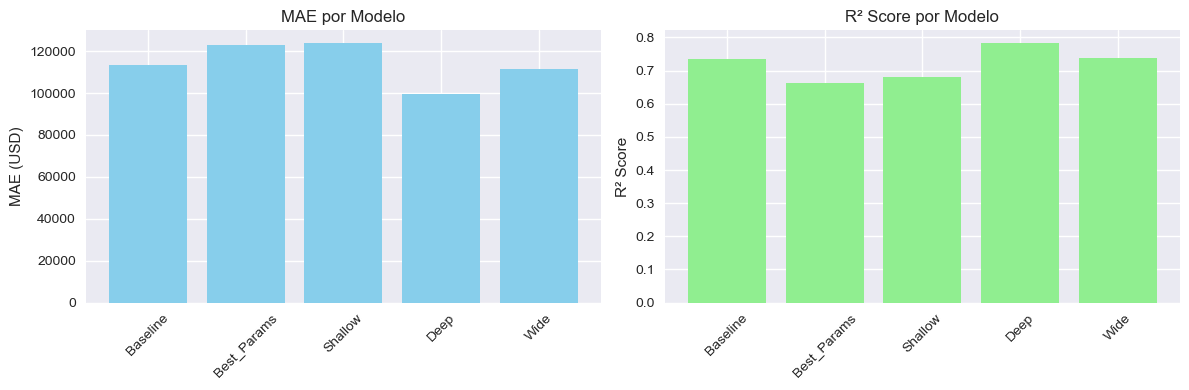


🏆 MEJOR MODELO: Deep
   MAE: $99,519
   R²: 0.782

📊 MEJORA vs Dataset Completo:
   Reducción de outliers: 0.2%
   Precio promedio reducido: $7,605


In [21]:
# Comparación visual
all_results = {'Baseline': baseline_metrics, 'Best_Params': best_metrics, **arch_results}

names = list(all_results.keys())
mae_values = [all_results[name]['mae'] for name in names]
r2_values = [all_results[name]['r2'] for name in names]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(names, mae_values, color='skyblue')
axes[0].set_title('MAE por Modelo')
axes[0].set_ylabel('MAE (USD)')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(names, r2_values, color='lightgreen')
axes[1].set_title('R² Score por Modelo')
axes[1].set_ylabel('R² Score')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Mejor modelo
best_name = min(all_results.keys(), key=lambda x: all_results[x]['mae'])
print(f"\n🏆 MEJOR MODELO: {best_name}")
print(f"   MAE: ${all_results[best_name]['mae']:,.0f}")
print(f"   R²: {all_results[best_name]['r2']:.3f}")
print(f"\n📊 MEJORA vs Dataset Completo:")
print(f"   Reducción de outliers: {(len(df) - len(df_filtered))/len(df)*100:.1f}%")
print(f"   Precio promedio reducido: ${(df['price'].mean() - df_filtered['price'].mean()):,.0f}")